## Import Required Libraries

In [95]:
import pandas as pd
import seaborn as sns
import numpy as np
import requests
from matplotlib import pyplot as plt
from datetime import datetime
from io import BytesIO
import plotly.graph_objects as go
import plotly.io as pio
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px

# plotly config needed for interactive graphs
init_notebook_mode(connected=True)

## Fetch Data & Setup Dataframe

#### Dataset Information
<a href="https://open.canada.ca/data/en/dataset/7643c948-d661-4d90-ab91-e9ac732fc737/resource/b6030624-6394-48f2-a86c-1d536c21bddc">
    Canada’s Energy Future 2023: Energy Supply and Demand Projections to 2050 - benchmark-prices-2023
</a>

In [96]:
'''
Dataset Information
---------------------
Canada’s Energy Future 2023: Energy Supply and Demand Projections to 2050 - benchmark-prices-2023
'''

DATA_URL = 'https://www.cer-rec.gc.ca/open/energy/energyfutures2023/benchmark-prices-2023.csv'
benchmark_prices = None

# fetch data from GOC and load it into pandas dataframe
response = requests.get(DATA_URL)
with BytesIO(response.content) as data:
    benchmark_prices = pd.read_csv(data)

# Filter out unwanted column 
benchmark_prices.drop('Unnamed: 0', axis=1, inplace=True)

## Reusable Graph & Table Functions

In [97]:
def format_table(dataframe, title, width):
    '''
    Formats a dataframe and returns a styled pandas table
    '''
    table = dataframe.style \
    .set_caption(title) \
    .hide(axis="index") \
    .format(precision=2) \
    .set_properties(**{'width': width, 'text-align': 'center'}) \
    .set_table_attributes("style='width: 100%'") \
    .set_table_styles([
        {
        'selector': 'th',
        'props': [('text-align', 'center')]
        },
        {
        'selector': 'caption',
        'props': [('text-align', 'center'), ('font-size', '16px')]
        }])

    return table

In [98]:
def create_line_graph(data, x, y, hue, title, y_label, caption, yticks, subtitle='', grouping=False, group_name='', legend_n_cols=1) -> None:
    '''
    Creates and shows a line graph based on the above parameters.
    This function will create a line graph based on any arbritrary data.
    '''
    # color and size
    palette = sns.color_palette("viridis", n_colors=data[hue].nunique())
    plt.figure(figsize=(10, 8))

    # plot the line based on grouping
    if grouping:
        sns.lineplot(data=data, x=x, y=y, hue=hue, style=group_name, dashes=True, palette=palette)
    else:
        sns.lineplot(data=data, x=x, y=y, hue=hue, palette=palette)

    # add title and subtitle
    plt.gca().text(0, 1.07, title, transform=plt.gca().transAxes, fontsize=14, verticalalignment='bottom', ha='left')
    if subtitle:
        plt.gca().text(0, 1.05, subtitle, transform=plt.gca().transAxes, verticalalignment='top', ha='left')
        
    # format axes
    plt.ylabel(y_label)
    plt.xlabel('')
    plt.yticks(yticks)

    # create and position legend
    bbox_to_anchor = (0.5 if not grouping else 0.25, -0.10)
    plt.legend(loc='upper center', bbox_to_anchor=bbox_to_anchor, ncol=legend_n_cols)

    # caption/source text
    plt.text(x=1, y=-0.3 if not grouping else -0.4, s=caption, transform=plt.gca().transAxes, ha='right', va='bottom', fontsize=12)
    
    # display final graph
    plt.grid(True, which='both', color='lightgray', linestyle='--', linewidth=0.5)
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

In [99]:
def create_interactive_line_graph(df, x, y, title, xAxisTitle, yAxisTitle):
    '''
    Creates and shows an interactive line graph using plotly based on the above parameters.
    '''
    # Create traces, one for each combination of Scenario and Variable
    traces = []
    first_scenario = df['Scenario'].iloc[0]
    for scenario in df['Scenario'].unique():
        for variable in df['Variable'].unique():
            df_filtered = df[(df['Scenario'] == scenario) & (df['Variable'] == variable)]
            traces.append(
                go.Scatter(
                    x=df_filtered[x],
                    y=df_filtered[y],
                    mode='lines+markers',
                    name=f"{scenario} - {variable}",
                    visible=(scenario == first_scenario)
                )
            )
    
    # Create layout with dropdown
    layout = go.Layout(
        title=title,
        xaxis=dict(title=xAxisTitle),
        yaxis=dict(title=yAxisTitle),
        autosize=True,
        updatemenus=[
            {
                'buttons': [
                    {
                        'args': [{'visible': [scenario in trace.name for trace in traces]}],
                        'label': scenario,
                        'method': 'update'
                    }
                    for scenario in df['Scenario'].unique()
                ],
                'direction': 'down',
                'showactive': True,
                'x': 0.5,
                'xanchor': 'center',
                'y': 1.12,
                'yanchor': 'top'
            }
        ],
        legend=dict(
            x=0,  
            y=-0.2,
            orientation="h",
            xanchor='left',
            yanchor='top'
        )
    )
    
    # Create the figure
    fig = go.Figure(data=traces, layout=layout)
    
    # Show the first scenario by default
    first_scenario = df['Scenario'].iloc[0]
    fig.update_layout(
        updatemenus=[
            {
                'buttons': [
                    {
                        'args': [{'visible': [scenario in trace.name for trace in traces]}],
                        'label': scenario,
                        'method': 'update'
                    }
                    for scenario in df['Scenario'].unique()
                ],
                'direction': 'down',
                'showactive': True,
                'active': list(df['Scenario'].unique()).index(first_scenario)
            }
        ]
    )
    
    # Show the figure
    fig.show()

## WTI Prices - Current Measures

In [100]:
current_measures_prices = benchmark_prices

# Filter the benchmark_prices table to:
# only have WTI prices for the 'Current Measures' Scenario
# only incluide years that are multiples of 5 starting at 2020
current_measures_prices = current_measures_prices[
    (current_measures_prices['Variable'] == 'West Texas Intermediate (WTI) - 2022 US$/bbl') &
    (current_measures_prices['Scenario'] == 'Current Measures') &
    (current_measures_prices['Year'] >= 2020) & 
    (current_measures_prices['Year'] % 5 == 0)
]

# Remove columns other than Year and Value
current_measures_prices = current_measures_prices[['Year', 'Value']]

# Update the column names for table
current_measures_prices.columns = ['Year', 'Price ($2022/bbl)']

# Create and style table to show
current_measures_table = format_table(
    dataframe=current_measures_prices,
    title='West Texas Intermediate (WTI) prices ($2022 per barrel) in the Current Measures scenario of the Canadian Energy Regulator’s Canada’s Energy Future (2023) report',
    width='50%'
)

# Visualize the table
current_measures_table

Year,Price ($2022/bbl)
2020,43.66
2025,76.67
2030,72.50
2035,72.50
2040,72.50
2045,72.50
2050,72.50


## Crude Oil Prices - Canada Net-Zero

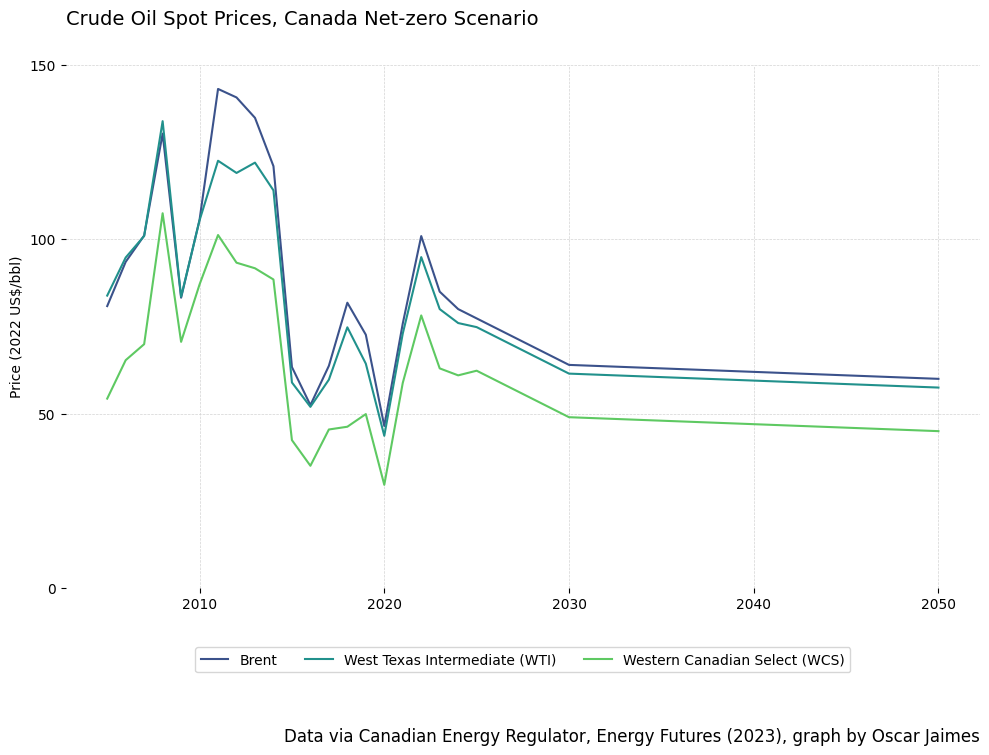

In [101]:
# filter for Canada Net-zero scenario
net_zero_prices = benchmark_prices[benchmark_prices['Scenario'] == 'Canada Net-zero'].copy()

# strip the 2022 US $/bbl from each of the variable names
net_zero_prices['Variable'] = net_zero_prices['Variable'].str.split('-').str[0].str.strip()

# filter out prices for Brent, WTI, and WCS
included = ['Brent', 'Western Canadian Select (WCS)', 'West Texas Intermediate (WTI)']
net_zero_prices = net_zero_prices[net_zero_prices["Variable"].isin(included)]

# Create & Show line graph for crude oil spot prices in Canda Net-zero Scenario
create_line_graph(
    data=net_zero_prices,
    x='Year',
    y='Value',
    hue='Variable',
    title='Crude Oil Spot Prices, Canada Net-zero Scenario',
    y_label='Price (2022 US$/bbl)',
    caption='Data via Canadian Energy Regulator, Energy Futures (2023), graph by Oscar Jaimes',
    yticks=[n for n in range(151) if n % 50 == 0],
    subtitle=None,
    legend_n_cols=3,
    grouping=False,
    group_name=None
)

## WCS Crude Oil Prices

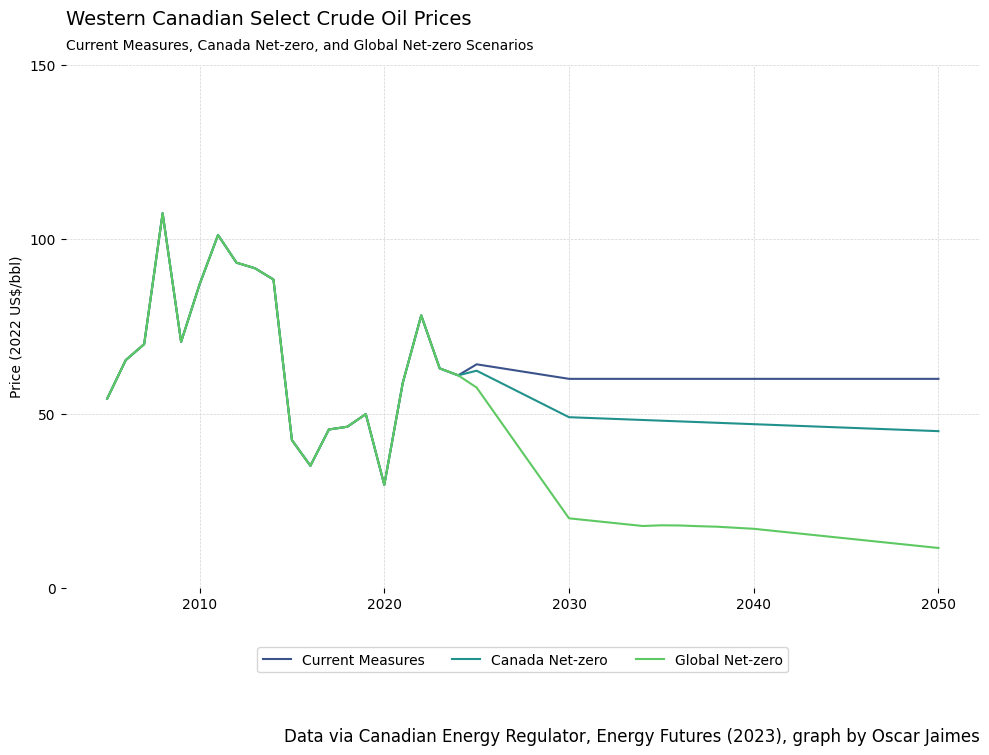

In [102]:
# filter benchmark prices to only include WCS Data
wcs_data = benchmark_prices[
    benchmark_prices["Variable"] == 'Western Canadian Select (WCS) - 2022 US$/bbl'
]

# show line graph for WCS prices across multiple scenarios
create_line_graph(
    data=wcs_data,
    x='Year',
    y='Value',
    hue='Scenario',
    title='Western Canadian Select Crude Oil Prices',
    y_label='Price (2022 US$/bbl)',
    caption='Data via Canadian Energy Regulator, Energy Futures (2023), graph by Oscar Jaimes',
    yticks=[i for i in range(151) if i % 50 == 0],
    subtitle='Current Measures, Canada Net-zero, and Global Net-zero Scenarios',
    legend_n_cols=3,
    grouping=False,
    group_name=None
)

## NIT Natural Gas Prices

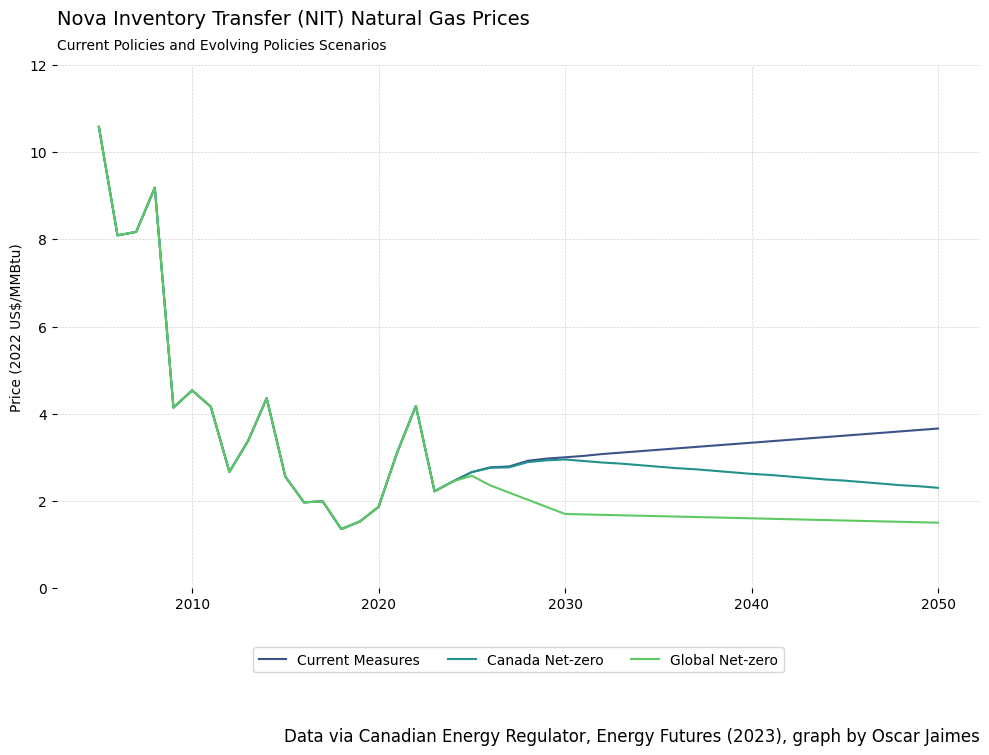

In [103]:
# filter benchmark prices to only include NIT Data
nit_data = benchmark_prices[
    benchmark_prices["Variable"] == 'Nova Inventory Transfer (NIT) - 2022 US$/MMBtu'
]

# create line graph of NIT prices across different scenarios
create_line_graph(
    data=nit_data,
    x='Year',
    y='Value',
    hue='Scenario',
    title='Nova Inventory Transfer (NIT) Natural Gas Prices',
    y_label='Price (2022 US$/MMBtu)',
    caption='Data via Canadian Energy Regulator, Energy Futures (2023), graph by Oscar Jaimes',
    yticks=[n for n in range(13) if n % 2 == 0],
    subtitle='Current Policies and Evolving Policies Scenarios',
    legend_n_cols=3,
    grouping=False,
    group_name=None
)

## Crude Oil Prices - Current & Global Net-zero

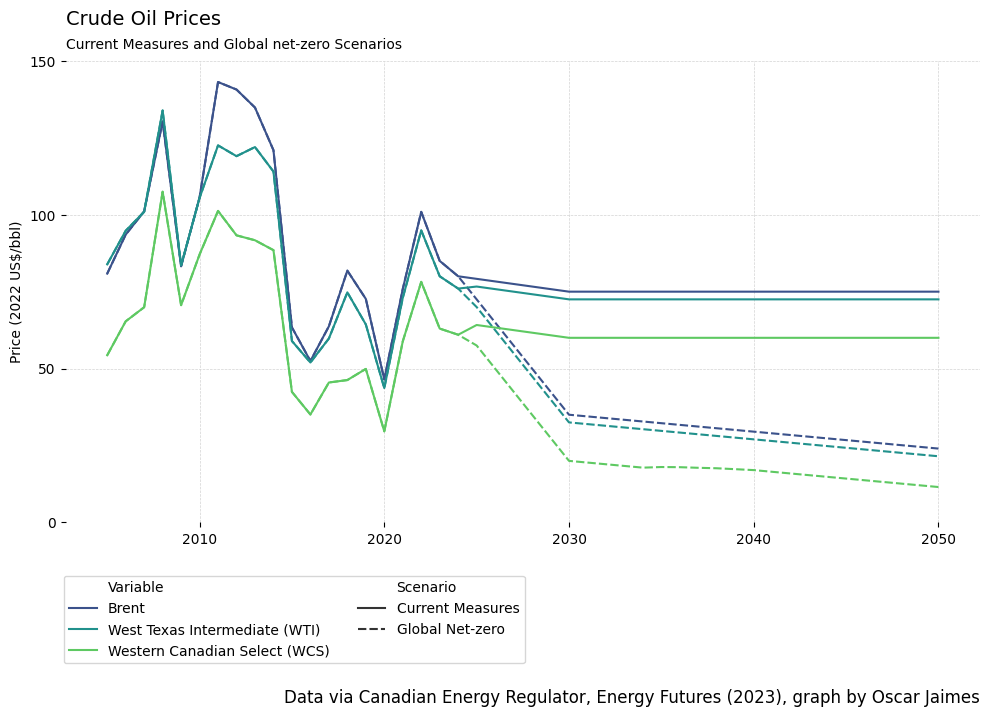

In [104]:
# filter for Current Measures and Global Net-zero scenarios
valid_scenarios = ['Current Measures', 'Global Net-zero']
oil_prices = benchmark_prices[benchmark_prices['Scenario'].isin(valid_scenarios)].copy()

# strip the 2022 US $/bbl from each of the variable names
oil_prices['Variable'] = oil_prices['Variable'].str.split('-').str[0].str.strip()

# filter out prices for Brent, WTI, and WCS
valid_types = ['Brent', 'Western Canadian Select (WCS)', 'West Texas Intermediate (WTI)']
oil_prices = oil_prices[oil_prices["Variable"].isin(valid_types)]


# Create line graph to show grouped oil prices across different scenarios"
create_line_graph(
    data=oil_prices,
    x='Year',
    y='Value',
    hue='Variable',
    title='Crude Oil Prices',
    subtitle='Current Measures and Global net-zero Scenarios',
    y_label='Price (2022 US$/bbl)',
    caption='Data via Canadian Energy Regulator, Energy Futures (2023), graph by Oscar Jaimes',
    yticks=[n for n in range(int(oil_prices['Value'].max() + 10)) if n % 50 == 0],
    grouping=True,
    group_name='Scenario',
    legend_n_cols=2
)


## Interactive Graphs

As an extension of the challenge graph, I wanted to visualize the data such that a user is able to interact with it. Instead of showing multiple line series on the same graph, I figured it would be a good idea to let a user choose what scenario they want to see prices for and then visually compare the changes.

The following graphs were created with the plotly library. You can:

- Filter the graph by Scenario
- Select/Unselect legend items to view in the graph
- Zoom into a bounding box on the graph
- Download the plot as a PNG
- Reset the view by double-clicking on the graph

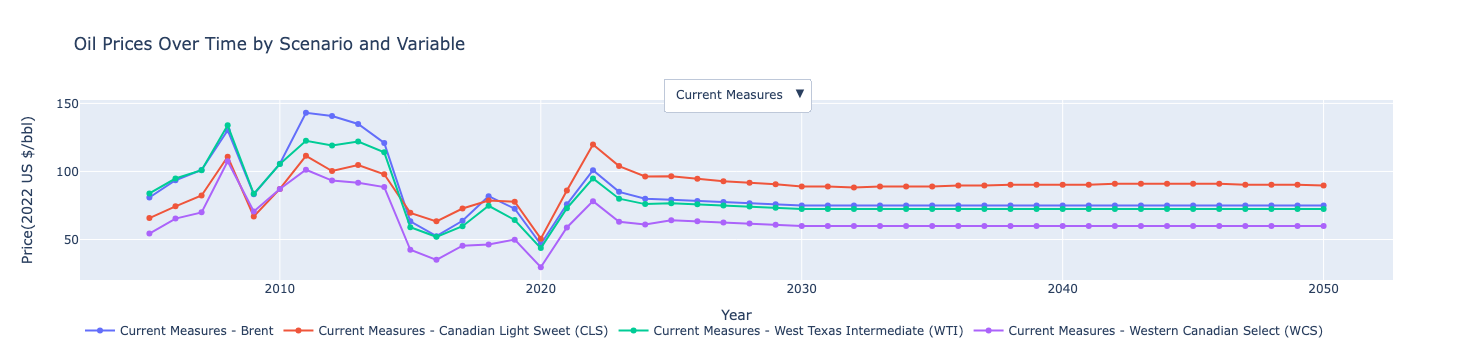

In [105]:
# strip the 2022 US $/bbl from each of the variable names
oil_prices = benchmark_prices
oil_prices['Variable'] = oil_prices['Variable'].str.split('-').str[0].str.strip()

# filter out prices for Brent, WTI, and WCS
valid_types = ['Brent', 'Western Canadian Select (WCS)', 'West Texas Intermediate (WTI)', 'Canadian Light Sweet (CLS)']
oil_prices = oil_prices[oil_prices["Variable"].isin(valid_types)]

# show interactive line graph
create_interactive_line_graph(
    df=oil_prices,
    x='Year',
    y='Value',
    title='Oil Prices Over Time by Scenario and Variable',
    xAxisTitle='Year',
    yAxisTitle='Price(2022 US $/bbl)'
)

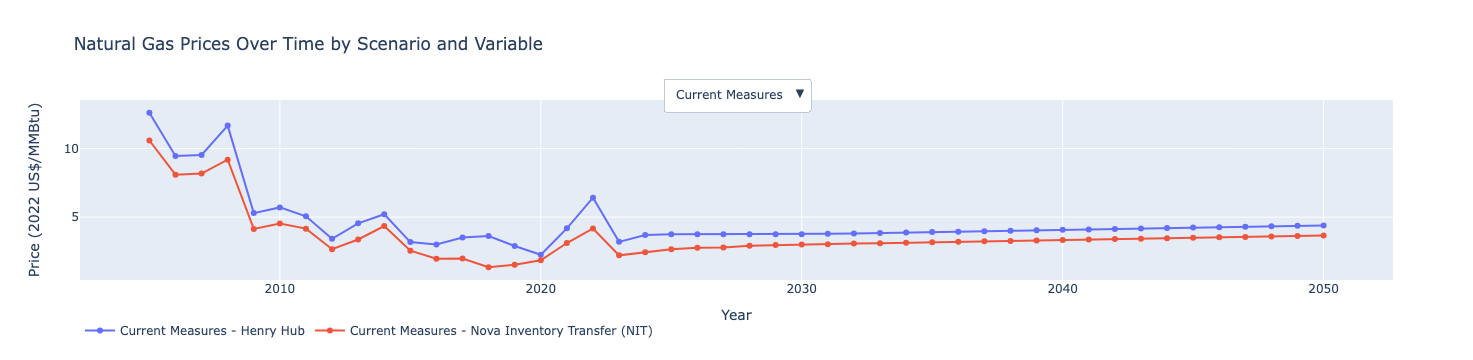

In [106]:
# strip the 2022 US $/bbl from each of the variable names
oil_prices = benchmark_prices
oil_prices['Variable'] = oil_prices['Variable'].str.split('-').str[0].str.strip()

# filter out prices for Brent, WTI, and WCS
valid_types = ['Brent', 'Western Canadian Select (WCS)', 'West Texas Intermediate (WTI)', 'Canadian Light Sweet (CLS)']
oil_prices = oil_prices[~oil_prices["Variable"].isin(valid_types)]

# show interactive line graph
create_interactive_line_graph(
    df=oil_prices,
    x='Year',
    y='Value',
    title='Natural Gas Prices Over Time by Scenario and Variable',
    xAxisTitle='Year',
    yAxisTitle='Price (2022 US$/MMBtu)'
)